In [37]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor
import torchvision.models as models

device = torch.device('gpu' if torch.cuda.is_available() else 'cpu')

In [38]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes= 2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            # Conv1
            nn.Conv2d(3, 64, kernel_size= 3, bias= False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace= True),
            nn.Dropout(0.3),
            # Conv2, Pool1
            nn.Conv2d(64, 64, kernel_size= 3, padding= 1, bias= False),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            # Conv3
            nn.Conv2d(64, 128, kernel_size=3 ,padding= 1, bias= False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),            
            # Conv4, Pool2
            nn.Conv2d(128, 128, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            # Conv5
            nn.Conv2d(128, 256, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv6
            nn.Conv2d(256, 256, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv7, Pool3
            nn.Conv2d(256, 256, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            # Conv8
            nn.Conv2d(256, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv9
            nn.Conv2d(512, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv10, Pool4
            nn.Conv2d(512, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2, stride= 2),

            # Conv11
            nn.Conv2d(512, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv12
            nn.Conv2d(512, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.4),
            # Conv13, Pool2d
            nn.Conv2d(512, 512, kernel_size= 3, padding= 1, bias= False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace= True),
            nn.MaxPool2d(kernel_size= 2, stride= 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias= False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        
        return F.log_softmax(x)

In [39]:
model = XAI()
model.to(device)
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Dropout(p=0.4, inplace=False)
    (11): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (12): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
   

In [40]:
# 특성 맵을 확인하기 위한 클래스

class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)

    def hook_fn(self, modeule, input, output):
        self.features = output.detach().numpy()

    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


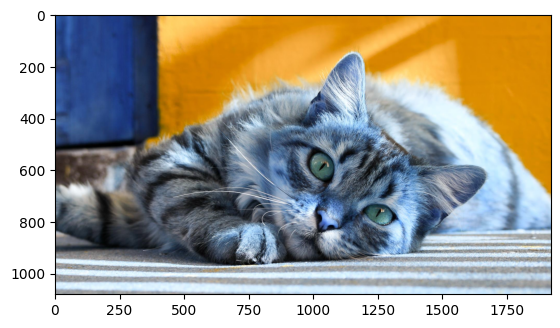

In [41]:
# 특성 맵을 가져올 이미지 호출
img = cv2.imread('data/cat.jpg')
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation= cv2.INTER_LINEAR)

# unsqueeze() : 1차원 데이터를 생성하는 함수
img = ToTensor()(img).unsqueeze(0) # 이미지 -> 텐서 -> 1차원
print(img.shape)

C:\Users\Ino\AppData\Local\Temp\ipykernel_5712\3066893188.py:89: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


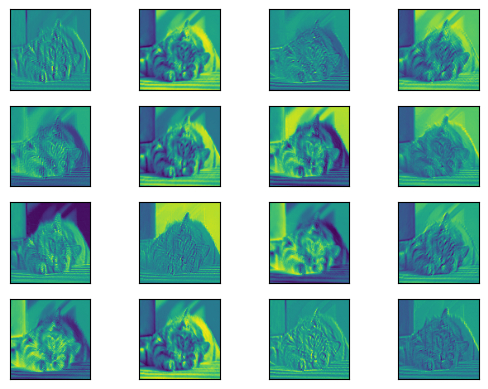

<Figure size 1200x800 with 0 Axes>

In [42]:
# Conv2d 특성 맵 확인
result = LayerActivations(model.features, 0) # 0번째 Conv2d의 특성 맵

model(img)
activations = result.features

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize= (12,8))
fig.subplots_adjust(left= 0, right= 1, bottom= 0, top= 1, hspace= 0.05, wspace= 0.05)

for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10 + col])
plt.show()

C:\Users\Ino\AppData\Local\Temp\ipykernel_5712\3066893188.py:89: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


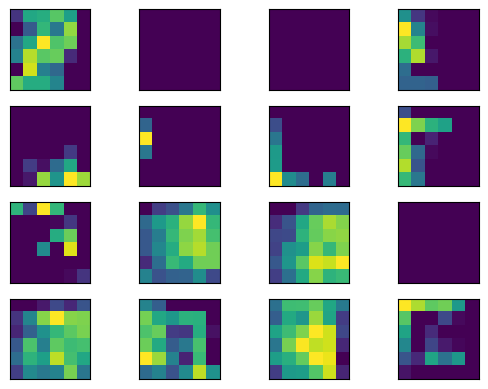

<Figure size 1200x800 with 0 Axes>

In [45]:
result_20 = LayerActivations(model.features, 40)

model(img)
activations_20 = result_20.features

fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize= (12,8))
fig.subplots_adjust(left= 0, right= 1, bottom= 0, top= 1, hspace= 0.05, wspace= 0.05)

for row in range(4):
    for col in range(4):
        axis = axes[row][col]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations_20[0][row*10 + col])
plt.show()